## PAPTO Tutorial 

The code used in this script is modified from https://github.com/tbardouille/papto_camcan

This method takes in a 1-dimensional time series of preprocessed electrophysiological data. A dataframe containing the characteristics (timing, frequency, power, etc.) of each detected burst is returned. 

Note that this tutorial relies on the utility script papto_functions.py available at https://github.com/lindseypower/BurstDetection_Tutorials

In [1]:
# Imports
import scipy.io as io
import scipy.signal as ss
import numpy as np 
import pandas as pd
from papto_functions import * 
import multiprocessing as mp
import os
import math
import seaborn as sbn
import mne

/export03/data/lindseyp/burst_methods_review/papto_functions.py:24: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
#  Read in one-dimensional time series (preprocessed)
file_name = 'sub-002_SomMotA_4_R.mat'
scout_mean_timecourses = io.loadmat(file_name)
data = np.squeeze(scout_mean_timecourses['Value'])

print(data.shape)

(1440000,)


In [3]:
# Downsample data to 1000 Hz 
data_len = 600
Fs = 1000  
data = ss.resample(data, Fs*data_len)

data = data[0:int(Fs*data_len/2)]
print(data.shape)

(300000,)


### 1. Select a Threshold

**This step is used to define an optimal threshold based on your data, however, this is optional. You may also choose to simply select a fixed threshold based on previous literature. If you would like to set a fixed threshold, proceed to step 2 and set 'thrFOM' to the value of your choosing.**

Calls find_bestThreshold_papto method from papto_functions.py 

Calculates a TFR and applies each listed threshold to select high power pixels in the TFR (using fooof-normalized TFR). Calculates correlation between number of high-power pixels and the average power of the signal. The best threshold is identified as that with the greatest correlation. 

Method adapted from Brady et al, 2022 (https://doi.org/10.1016/j.neuroimage.2022.118974)

In [4]:
# TFR params #
fmin = 15.0         # Hertz (integer)
fmax = 30.0        # Hertz (integer)
fstep = 1.0         # Hertz (integer)
width = 10        # width of the morlet wavelet
fVec = np.arange(fmin, fmax+1, fstep)

# Test different thresholds to select the best one for identifying high power events 
thresholds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
df_plot = find_bestThreshold_papto(data, thresholds, Fs, width, fVec, fmin, fmax)

Effective window size : 1.000 (s)


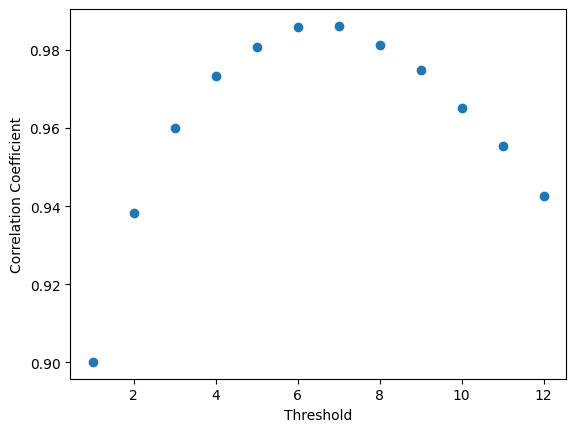

In [5]:
# Plot the correlation between percent thresholded pixels and average power for each threshold 
mean_coef_list = []
new_thresholds = []
for threshold in thresholds:
    sub_df = df_plot[df_plot['threshold']==threshold]
    mean_coef = np.mean(sub_df['coef'])
    if not math.isnan(mean_coef):
        mean_coef_list.append(mean_coef)
        new_thresholds.append(threshold)
plt.scatter(new_thresholds, mean_coef_list)
plt.xlabel('Threshold')
plt.ylabel('Correlation Coefficient')
plt.show()

In [6]:
# Overall best threshold: maximum correlation coefficient
max_coef = np.max(np.asarray(mean_coef_list))
max_threshold = new_thresholds[np.where(mean_coef_list==max_coef)[0][0]]
print('Best Threshold:')
print(max_threshold)

Best Threshold:
7


### 2. Compute a Time-Frequency Representation (TFR)

Calls TFR_via_morlet_wavelet from spectralevents_functions.py 

Calculates the TFR (in spectral power) of a time-series waveform by convolving in the time-domain with a Morlet wavelet. 

Method adapted from Shin et al, 2017 (https://doi.org/10.7554/eLife.29086) and Brady et al, 2022 (https://doi.org/10.1016/j.neuroimage.2022.118974)

In [7]:
# Make a TFR for data
chan_data = np.reshape(data, (data.shape[0],1)) #reshapes because function expects epochs 
TFR, tVec = TFR_via_morlet_wavelet(chan_data, fVec, Fs)

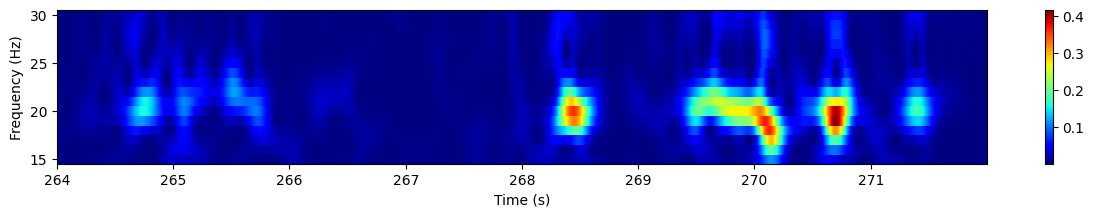

In [8]:
# Plot sample of TFR
TFR_crop = np.asarray(TFR)[:,:,264000:272000]
fig = plt.figure(figsize=(15,2))
im = plt.pcolor(tVec[264000:272000], fVec, np.squeeze(TFR_crop), cmap='jet')
fig.colorbar(im)
plt.xlabel('Time (s)')
plt.ylabel ('Frequency (Hz)')
plt.show()

### 3. Normalize TFR using specparam (FOOOF)

Fits the aperiodic component of the power spectrum using the specparam method (fitting oscillations and one over f; FOOOF) by Donoghue et al, 2020 (https://doi.org/10.1038/s41593-020-00744-x). 

Calculates a normalization factor based on the exponent and offset of the aperiodic component of the signal as described in Brady et al, 2022 (https://doi.org/10.1016/j.neuroimage.2022.118974) and multiplies the TFR by this factor.

In [9]:
# Calculate PSD
PSD, PSD_fVec = mne.time_frequency.psd_array_welch(chan_data.T, Fs, fmin=1, fmax=80, n_fft=1000, n_overlap=900)
PSD = interpolate_60Hz_notch(PSD, PSD_fVec)

# FOOOF modeling
fm = FOOOF(peak_width_limits=(2,10), max_n_peaks=4, aperiodic_mode='fixed', min_peak_height=0.05, peak_threshold=1.5)
fm.fit(PSD_fVec, np.squeeze(PSD), [fmin,fmax])
exponent = fm.get_params('aperiodic_params', 'exponent')
offset = fm.get_params('aperiodic_params', 'offset')

# generate normalization factor nc from aperiodic offset and exponent
nc = (fVec**(exponent)) / (10**offset)

# normalize the TFR
TFR_papto = TFR * nc[None,:,None] 

Effective window size : 1.000 (s)


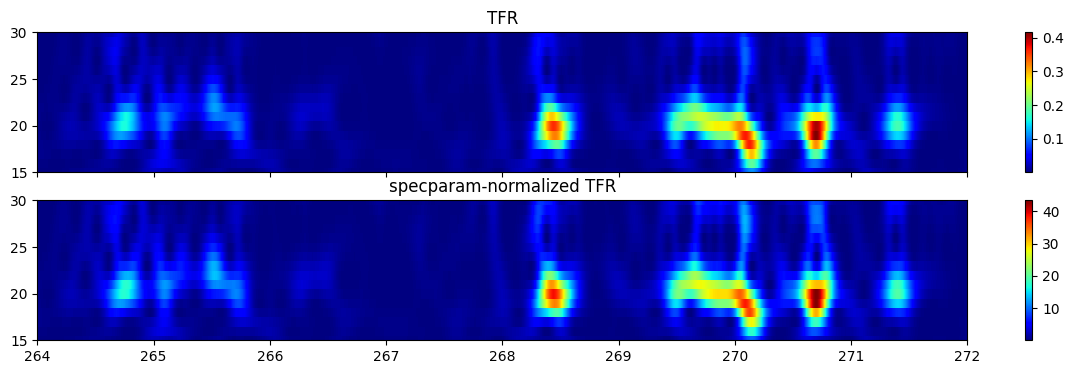

In [10]:
# Plot TFR before and after normalizing based on aperiodic background
fig, axs = plt.subplots(2,1, figsize=(15,4))
scale_val = 20

# Plot original TFR
TFR_crop = np.asarray(TFR)[:,:,264000:272000]
im = axs[0].pcolor(tVec[264000:272000], fVec, np.squeeze(TFR_crop), cmap='jet')
axs[0].set_xticklabels([])
axs[0].set_xlim(264,272)
axs[0].set_ylim(15,30)
axs[0].set_title('TFR')
fig.colorbar(im)

# Plot specparam-normalized TFR 
TFR_papto_crop = TFR_papto[:,:,264000:272000]
im2 = axs[1].pcolor(tVec[264000:272000], fVec, np.squeeze(TFR_papto_crop), cmap='jet')
axs[1].set_xlim(264,272)
axs[1].set_ylim(15,30)
axs[1].set_title('specparam-normalized TFR')
fig.colorbar(im2)

### 4. Identify High-Power Spectral Events 

Calls spectralevents_find from papto_functions.py 

Finds spectral events by first retrieving all local maxima in the TFR using python equivalent of imregionalmax (MATLAB), then selects suprathreshold peaks within the frequency band of interest

Method adapted from Shin et al, 2017 (https://doi.org/10.7554/eLife.29086) and Brady et al, 2020 (https://doi.org/10.1016/j.neuroimage.2020.117245)

In [11]:
# Set up some parameters for burst detection #
findMethod = 1  
thrFOM = max_threshold # Here you may wish to overwrite this with a specified threshold of your choosing
footprintFreq = 4
footprintTime = 80
threshold = 0.00
neighbourhood_size = (footprintFreq,footprintTime)

# Set all class labels to the same value 
numTrials = TFR_papto.shape[0]
classLabels = [1 for x in range(numTrials)]
        
# Use same amplitude thresholding to find spectral events based on TFR
spectralEvents = spectralevents_find (findMethod, thrFOM, tVec,
    fVec, TFR_papto, classLabels, neighbourhood_size, threshold, Fs)

# Create a dataframe of burst characteristics    
df = pd.DataFrame(spectralEvents)
burst_df = df[df['Peak Power']>max_threshold]

burst_df.head(5)

/export03/data/lindseyp/burst_methods_review/papto_functions.py:325: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  data_max = filters.maximum_filter(data, neighbourhood_size)
/export03/data/lindseyp/burst_methods_review/papto_functions.py:327: DeprecationWarning: Please import `minimum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  data_min = filters.minimum_filter(data, neighbourhood_size)


,Trial,Hit/Miss,Peak Frequency,Lower Frequency Bound,Upper Frequency Bound,Frequency Span,Peak Time,Event Onset Time,Event Offset Time,Event Duration,Peak Power,Normalized Peak Power,Outlier Event
16,0,1,15.0,15.0,17.0,6,22.838,22.709,22.941,0.232,7.682276,15.278019,True
77,0,1,15.0,15.0,17.0,6,115.031,114.737,115.203,0.466,9.766408,19.422809,True
96,0,1,15.0,15.0,16.0,4,146.273,146.069,146.424,0.355,7.113466,14.146806,True
159,0,1,15.0,15.0,17.0,6,215.278,215.169,215.407,0.238,7.071452,14.063252,True
260,0,1,16.0,15.0,24.0,18,58.983,58.882,59.191,0.309,8.419724,14.866100,True


In [12]:
# Record burst rate 
burstRate = burst_df.shape[0]/(chan_data.shape[0]/Fs)
print("Burst Rate:")
print(burstRate)

Burst Rate:
1.09


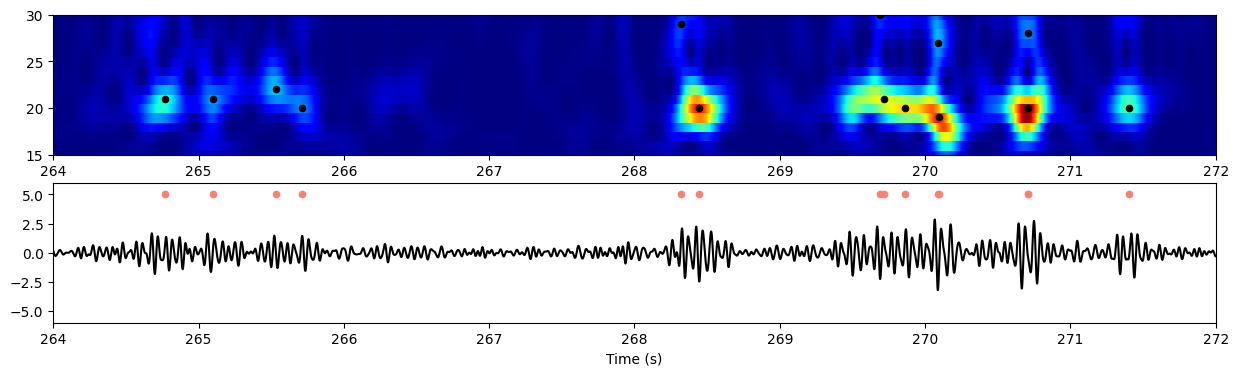

In [13]:
# Plot showing where the bursts are identified in the TFR along with a visualization of the corresponding times in the raw signal 
fig, axs = plt.subplots(2,1, figsize=(15,4))
scale_val = 20

# Plot TFR with overlaid burst times/frequencies 
TFR_crop = TFR_papto[:,:,264000:272000]
im = axs[0].pcolor(tVec[264000:272000], fVec, np.squeeze(TFR_crop), cmap='jet')
axs[0].scatter(burst_df['Peak Time'], burst_df['Peak Frequency'] ,c='black',s=scale_val,zorder=1)
axs[0].set_xlim(264,272)
axs[0].set_ylim(15,30)

# Plot indication of burst peak times with respect to raw (bandpassed) time series
beta_filt_dat = mne.filter.filter_data(np.squeeze(chan_data), Fs, l_freq=15.0, h_freq=30.0,verbose=False)
times = np.arange(0,chan_data.shape[0])/Fs
axs[1].plot(times,beta_filt_dat,zorder=0,c='black')
axs[1].scatter(burst_df['Peak Time'], [5]*len(burst_df['Peak Time']) ,c='salmon',s=scale_val,zorder=1)
axs[1].set_ylim(-6,6)
axs[1].set_xlim(264,272)
plt.xlabel('Time (s)')

plt.show()

In [14]:
burst_df.to_csv('papto_bursts.csv')